In [7]:
import math

class Tree:
    
    def __init__(self, current_value, strike_value, prop_p, risk_free_rate, time, volatility, steps):
        # Declare
        self.k = strike_value
        self.s = current_value
        self.p = prop_p
        self.r = risk_free_rate
        self.dt = time/steps
        self.v = volatility
        self.t = 0
        self.steps = steps
        self.tt = time
        
        # Make
        self.node_loc = {}
        self.u = math.exp(self.v * ((self.dt) ** 0.5))
        self.d = math.exp(-self.v * ((self.dt) ** 0.5))
        
        first = Node(current_value, (0, 0), None, self.t)
        self.current_layer = [first]
        self.tree = {first.loc:first}
        
    def run(self, option):
        '''
        Excecute the value loop and the pricing loop
        '''
        # First set the values
        for i in range(self.steps):
            self.step(i)
        
        # Set final option price
        self.final(option)
        
        # Set all prices in reverse order
        busy = True
        while busy:
            busy = self.reverse_step()
        
        print(self.current_layer[0])
        
    def step(self, layer):
        # initialize new layer
        next_layer = []
        self.node_loc[layer] = []
        
        # Increase time
        self.t += self.dt
        for i in self.current_layer:
            # calculate new prices
            value_up = i.value * self.u
            value_down = i.value * self.d
            
            # Up or down node, if not already made
            if not i.NN[0] in self.node_loc[layer]:
                up_node = Node(value_up, i.NN[0], i.loc, self.t)
                next_layer.append(up_node)
                
                # Track nodes
                self.node_loc[layer].append(i.NN[0])
                self.tree[up_node.loc] = up_node
                
            if not i.NN[1] in self.node_loc[layer]:
                down_node = Node(value_down, i.NN[1], i.loc, self.t)
                next_layer.append(down_node)
                
                # Track nodes
                self.node_loc[layer].append(i.NN[1])
                self.tree[down_node.loc] = down_node
        
        # Next layer becomes current
        self.current_layer = next_layer
            
    def final(self, sign='put'):
        '''
        Set last layer option price
        '''
        # 0 or profit
        if sign == 'call':
            for i in self.current_layer:
                i.price = i.value - self.k if i.value - self.k > 0 else 0
        else:
            for i in self.current_layer:
                i.price = self.k - i.value if self.k - i.value > 0 else 0
        
    def reverse_step(self):
        # Current layer lists
        next_layer = []
        locs = []
        
        # Backtrace nodes and price them
        for node in self.current_layer:
            previous_node = self.tree[node.prev]
            
            # No double pricing
            if previous_node.loc in locs:
                continue
            
            previous_node.set_price(self.p, self.r, self.tree)
            next_layer.append(previous_node)
            locs.append(previous_node.loc)
        
        # Check if finished
        self.current_layer = next_layer
        if not next_layer[0].loc[0] == 0:
            return True
        else:
            return False
        
    
class Node:
    
    def __init__(self, value, loc, prev, t):
        self.value = value
        self.loc = loc
        self.prev = prev
        self.t = t
        self.NN = [(loc[0] + 1, loc[1] + 1), (loc[0] + 1, loc[1])]
        self.price = 0
        self.delta = 0
    
    def set_price(self, p, rate, tree):
        '''
        Set price of option node
        '''
        # Get future nodes (maybe needs to be shifted at call and put)
        u_node = tree[self.NN[1]]
        d_node = tree[self.NN[0]]
        
        # Get future option price
        up_price = u_node.price
        down_price = d_node.price
        
        # Calculate todays value and thus option price now
        free_lunch = math.exp(-rate * self.t)
        price = (p * up_price + (1 - p) * down_price) * free_lunch

        # Set price, 0 or profit
        self.price = max([0, price])
        self.delta = abs(u_node.price - d_node.price) / abs(u_node.value - d_node.value)
    
    def __str__(self):
        '''
        Print all variables of the option node 
        '''
        var = {'value':self.value, "loc":self.loc, "prev":self.prev, 
               "NN": self.NN,  "price": self.price, "t":self.t, "delta":self.delta}
        s = ''
        for v in var.items():
            s += v[0] + " : " + str(v[1]) + "\n"
            
        return s
        

In [8]:
# Example PUT option
T = Tree(
         current_value=50, 
         strike_value=50, 
         prop_p=0.5076, 
         risk_free_rate=0.10, 
         time=5/12, 
         volatility=0.40,
         steps=5
        )

In [9]:
T.run('call')

value : 50
loc : (0, 0)
prev : None
NN : [(1, 1), (1, 0)]
price : 5.613783948393844
t : 0
delta : 0.549166891476583



In [15]:
print(T.tree[(5,4)])

value : 70.69912290402584
loc : (5, 4)
prev : (4, 4)
NN : [(6, 5), (6, 4)]
price : 20.69912290402584
t : 0.41666666666666674
delta : 0



In [23]:
import random

r = [random.randint(0, 6) for i in range(100)]
len([ i for n,i in enumerate(r) if int(n%(100/75)) == 0])

75

In [24]:
import Julien.test_code_julien as jc

In [26]:
B = jc.BlackScholes(1, 99, 100, 0.06, 0.4, 100)

In [27]:
B.create_price_path()

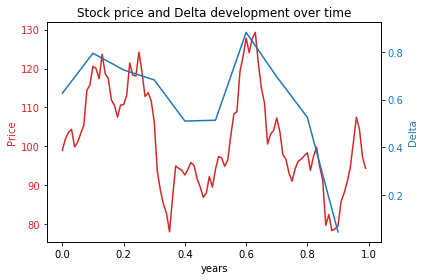

In [29]:
B.plot_price_path(steps=10)